In [5]:
import pandas as pd
import os

usa_csv_files = [
    'data/2018-climate-usa.csv',
    'data/2019-climate-usa.csv',
    'data/2020-climate-usa.csv',
]

eu_csv_files = [
    'data/2018-climate-eu.csv',
    'data/2019-climate-eu.csv',
    'data/2020-climate-eu.csv',
]

# combine and export csv files
combined_usa = pd.concat([pd.read_csv(f, lineterminator='\n') for f in usa_csv_files])
combined_eu = pd.concat([pd.read_csv(f, lineterminator='\n') for f in eu_csv_files])

combined_usa.to_csv('data/combined-usa.csv', index=False, lineterminator='\n')
combined_eu.to_csv('data/combined-eu.csv', index=False, lineterminator='\n')

In [8]:
import re
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer

usa_df = pd.read_csv('data/combined-usa.csv', lineterminator='\n')
eu_df = pd.read_csv('data/combined-eu.csv', lineterminator='\n')

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def clean_tweet(text):
    # remove twitter Return handles (RT @xxx:)
    text = np.vectorize(remove_pattern)(text, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    text = np.vectorize(remove_pattern)(text, "@[\w]*")
    # remove URL links (httpxxx)
    text = np.vectorize(remove_pattern)(text, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    text = np.core.defchararray.replace(text, "[^a-zA-Z#]", " ")
    return text

usa_df['Content'] = usa_df['Content'].astype(str).apply(clean_tweet)
eu_df['Content'] = eu_df['Content'].astype(str).apply(clean_tweet)

# initialize VADER
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(tweet):
    if isinstance(tweet, str):
        return sia.polarity_scores(tweet)['compound']
    else:
        return 0

def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

usa_df['Sentiment Score'] = usa_df['Content'].apply(analyze_sentiment)
usa_df['Sentiment Label'] = usa_df['Sentiment Score'].apply(label_sentiment)
usa_df.to_csv('data/usa-sentiment-vader.csv', index=False)

eu_df['Sentiment Score'] = eu_df['Content'].apply(analyze_sentiment)
eu_df['Sentiment Label'] = eu_df['Sentiment Score'].apply(label_sentiment)
eu_df.to_csv('data/eu-sentiment-vader.csv', index=False)

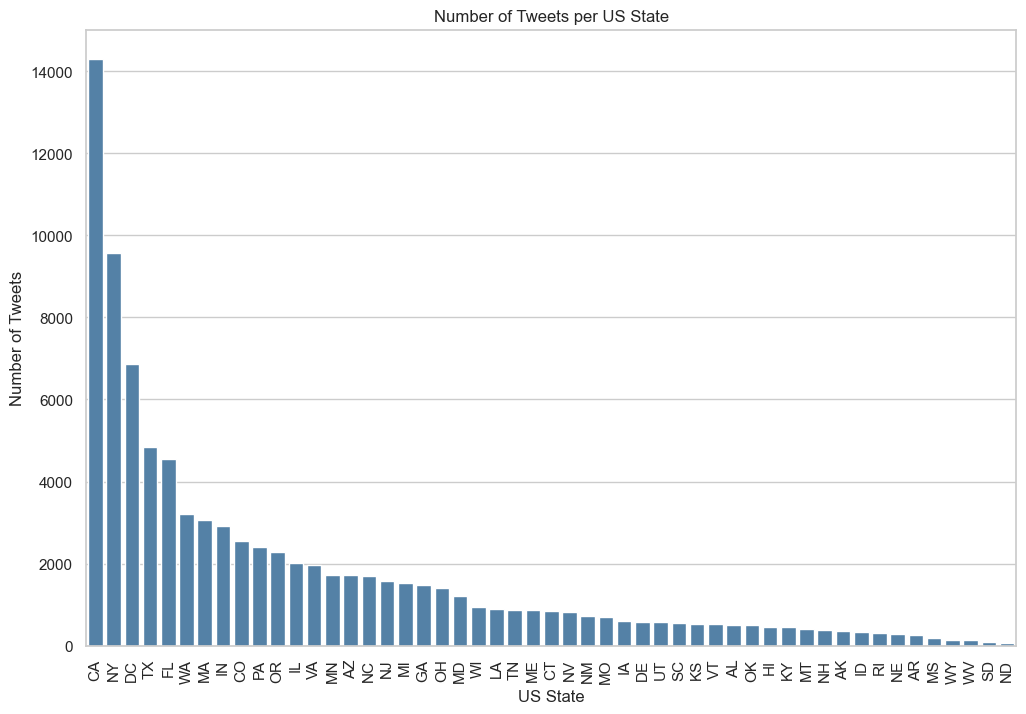

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/usa-sentiment-vader.csv')

state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington DC': 'DC', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# map full state names to abbreviations
df['State Abbreviation'] = df['Filtered Location'].map(state_abbreviations)
state_counts = df['State Abbreviation'].value_counts()

# plot number of tweets per state
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.barplot(x=state_counts.index, y=state_counts.values, color='steelblue')
plt.title('Number of Tweets per US State')
plt.xlabel('US State')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)
plt.show()

In [15]:
import plotly.express as px

state_sentiment = df.groupby('State Abbreviation')['Sentiment Score'].mean().reset_index()
state_sentiment.columns = ['State Abbreviation', 'Average Sentiment']

fig = px.choropleth(state_sentiment, 
                    locations='State Abbreviation', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Average Sentiment',
                    color_continuous_scale='RdYlGn',  # red to green color scale
                    range_color=(-0.1, 0.1))

fig.update_layout(title_text='Average Sentiment per US State')
fig.show()

In [14]:
variation = df.groupby('State Abbreviation')['Sentiment Score'].std().reset_index()
variation.columns = ['State Abbreviation', 'Sentiment Variation']

# Create a bar chart using Plotly
fig = px.bar(variation, x='State Abbreviation', y='Sentiment Variation',
             title='Total Sentiment Variation by State',
             labels={'Sentiment Variation': 'Total Sentiment Variation'},
             color_discrete_sequence=['steelblue'],
             range_y=[0.4, 0.5]) 

# Show the figure
fig.show()